In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


In [175]:
df = pd.read_csv('/content/set2.csv')

In [176]:
df.head()

,date,open,high,low,close,volume,adjclose,sentiment_bert
0,7/23/2012,21.228571,21.639286,20.989643,21.565357,487975600,18.257217,-1
1,7/24/2012,21.692142,21.774286,21.375357,21.461430,565132400,18.169228,1
2,7/27/2012,20.536072,20.922501,20.413929,20.898571,403936400,17.692717,0
3,7/30/2012,21.104286,21.408571,20.993570,21.251072,379142400,17.991146,0
4,7/31/2012,21.543928,21.846430,21.525715,21.812857,462327600,18.466757,-1


In [177]:
df['date'] = pd.to_datetime(df.date)


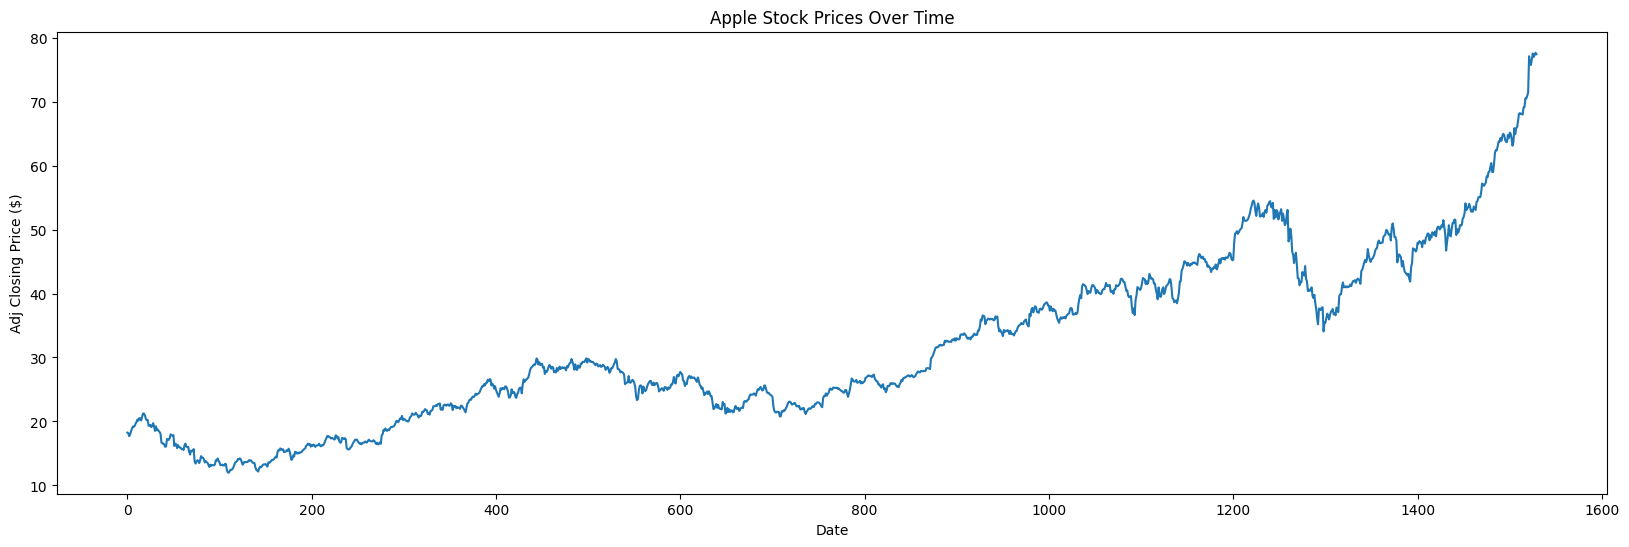

In [178]:
plt.figure(figsize=(20, 6))
plt.plot(df["adjclose"])
plt.xlabel("Date")
plt.ylabel("Adj Closing Price ($)")
plt.title("Apple Stock Prices Over Time")
plt.show()

In [179]:
# Set interceptate column as the index
newdf=df.set_index('date')

#To model returns we will use daily % change
daily = newdf['adjclose'].pct_change()
daily.dropna(inplace = True)

#Resample returns per month and take STD as measure of volatility
monthly=daily.resample("M").std()*np.sqrt(12)



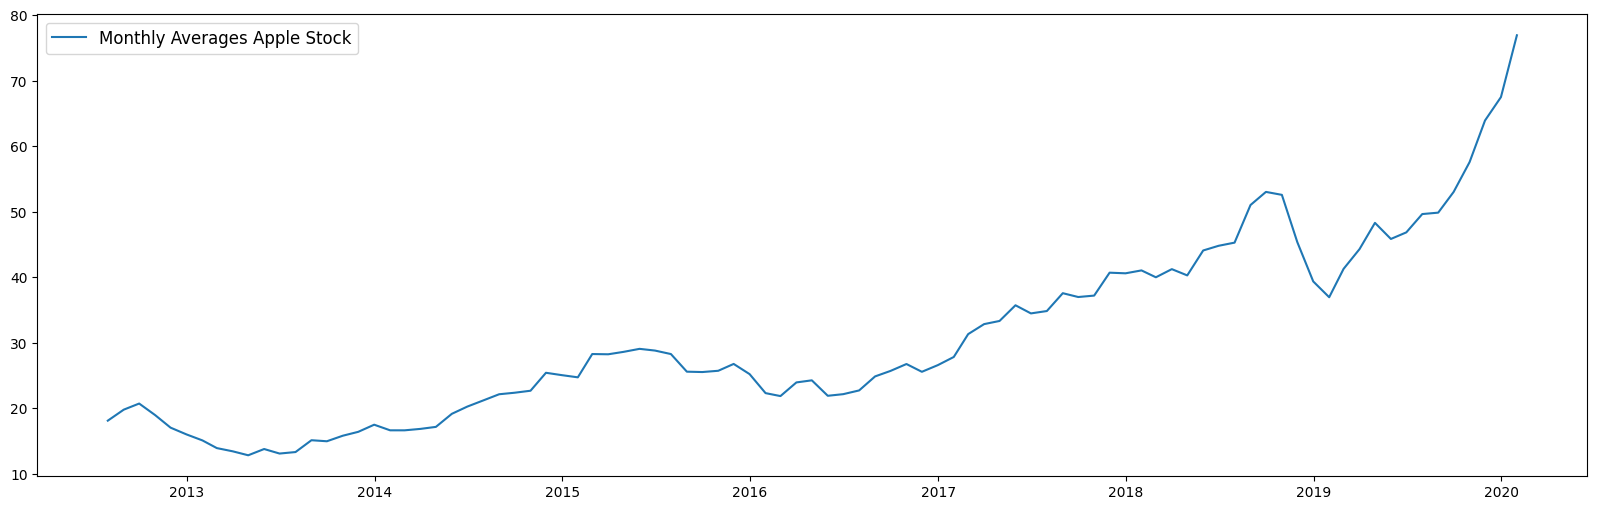

In [180]:
# Resample the data to the monthly level
monthly_mean = newdf['adjclose'].resample('M').mean()
monthly_data = monthly_mean.to_frame()
##Monthly Stock Price
fig = plt.figure(figsize=(20,6))
plt.plot(monthly_data['adjclose'],label='Monthly Averages Apple Stock')
plt.legend(prop={'size': 12})
plt.show()

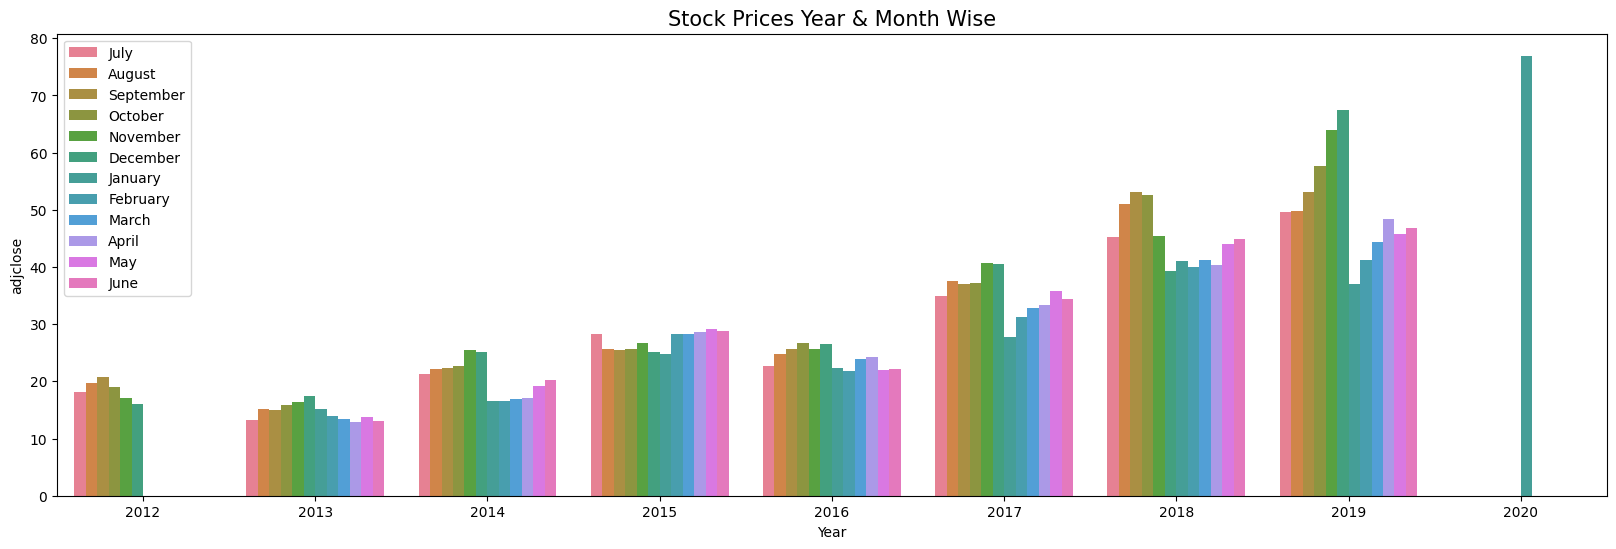

In [181]:
monthly_data['Year'] = monthly_data.index.year
monthly_data['Month'] = monthly_data.index.strftime('%B')
monthly_data['Quarter'] = monthly_data.index.quarter
fig, ax = plt.subplots(figsize=(20,6))
palette = sns.color_palette("mako_r", 4)
a = sns.barplot(x="Year", y="adjclose",hue = 'Month',data=monthly_data)
a.set_title("Stock Prices Year & Month Wise",fontsize=15)
plt.legend(loc='upper left')
plt.show()

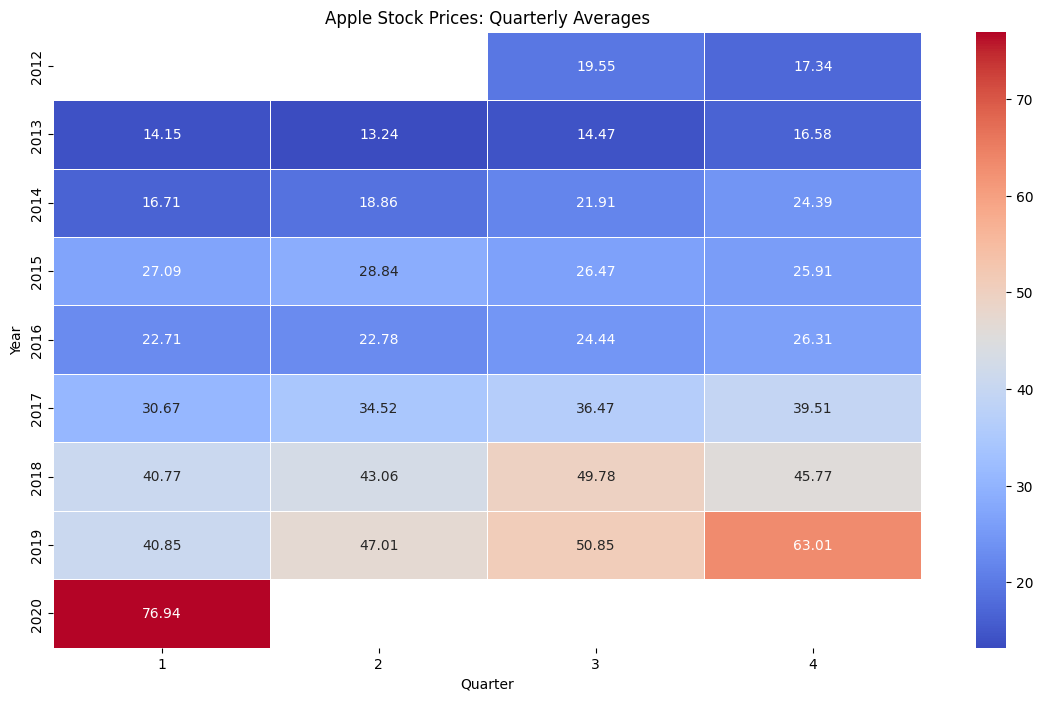

In [182]:
quarter = monthly_data.groupby(["Year", "Quarter"])["adjclose"].mean().unstack()
plt.figure(figsize=(14, 8))
sns.heatmap(quarter, cmap="coolwarm", annot=True, fmt=".2f", linewidths=.5)
plt.title("Apple Stock Prices: Quarterly Averages")
plt.show()

<Figure size 3000x1200 with 0 Axes>

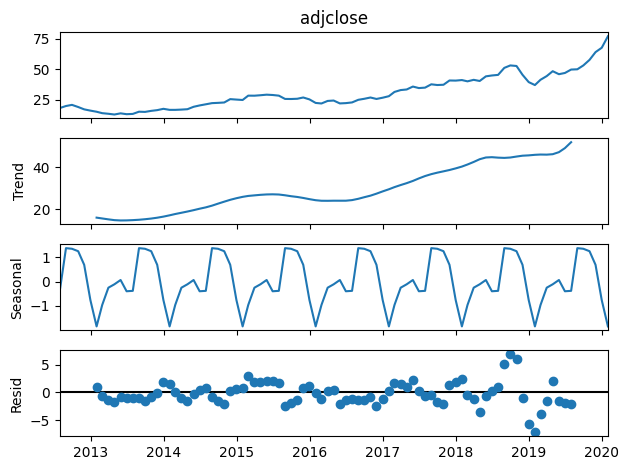

In [183]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

plt.figure(figsize=(30,12))
decomposed_series = sd(monthly_data['adjclose'])
decomposed_series.plot()
plt.show()

<Axes: xlabel='date'>

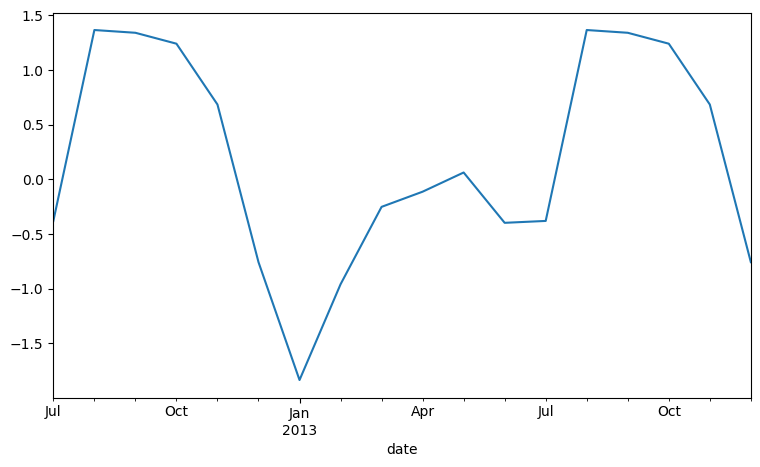

In [184]:
##Drilling Down and Observing Seasonality
fig = plt.figure(figsize=(9,5))
decomposed_series.seasonal['2012':'2013'].plot()

In [185]:
from statsmodels.tsa.stattools import adfuller

def ad_fuller_func(X):
  result_ad_fuller = adfuller(X)
  print('ADF Statistic: %f' % result_ad_fuller[0])
  print('p-value: %f' %result_ad_fuller[1])
  print('Critical Values:')
  for key, value in result_ad_fuller[4].items():
   print('\t%s: %.3f' % (key, value))

  if result_ad_fuller[0] < result_ad_fuller[4]['5%']:
    print('Reject Null Hypothesis- Time Series is Stationary')
  else:
    print('Failed to Reject Null Hypothesis- Time Series is Non-Stationary')

ad_fuller_func(monthly_data['adjclose'])

ADF Statistic: 1.745780
p-value: 0.998235
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
Failed to Reject Null Hypothesis- Time Series is Non-Stationary


Text(0.5, 0, 'Lags')

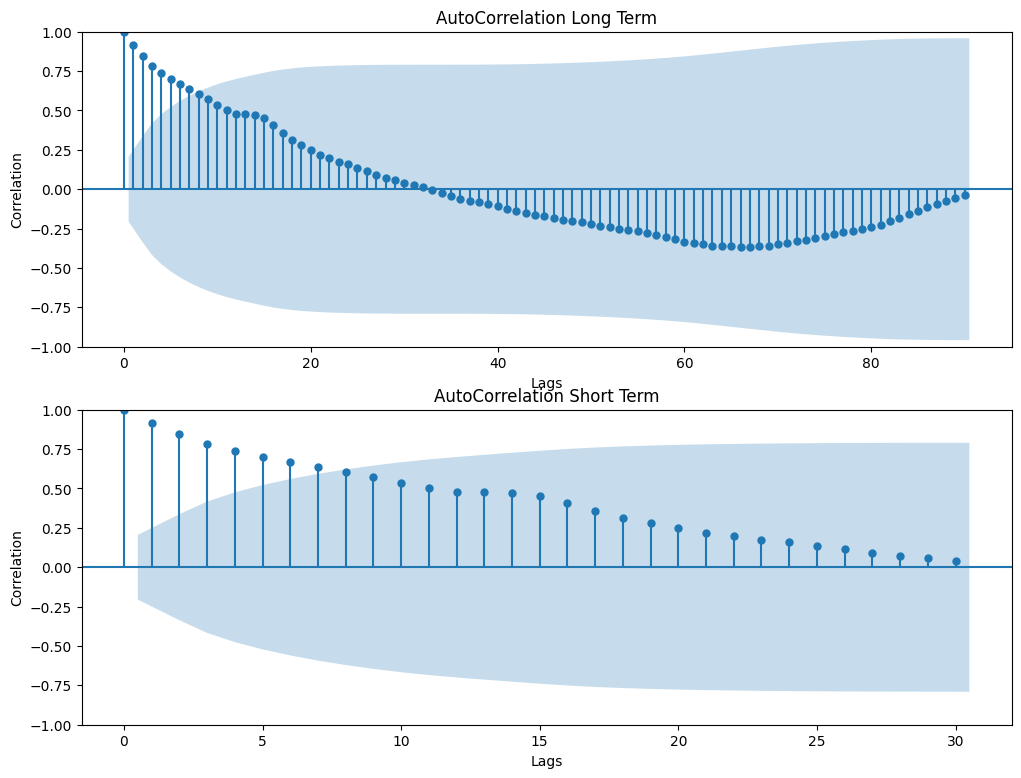

In [186]:
from statsmodels.graphics.tsaplots import plot_acf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
acf = plot_acf(monthly_data['adjclose'],lags=90,ax=ax1)
ax1.set_title('AutoCorrelation Long Term')
acf = plot_acf(monthly_data['adjclose'],lags=30,ax=ax2)
ax2.set_title('AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')

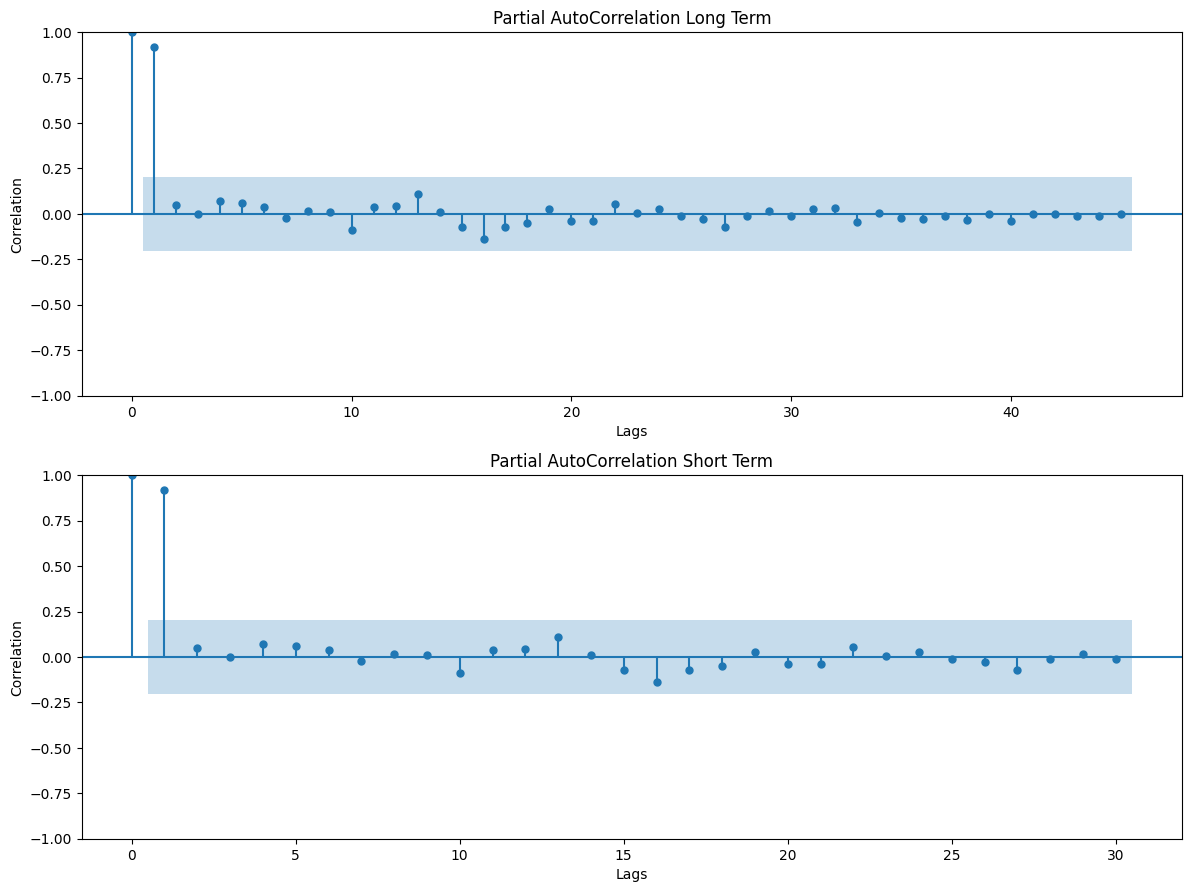

In [187]:
from statsmodels.graphics.tsaplots import plot_pacf

fig,(ax1,ax2) = plt.subplots(2,figsize=(12,9))
pacf = plot_pacf(monthly_data['adjclose'],lags=45,ax=ax1)
ax1.set_title('Partial AutoCorrelation Long Term')
pacf = plot_pacf(monthly_data['adjclose'],lags=30,ax=ax2)
ax2.set_title('Partial AutoCorrelation Short Term')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

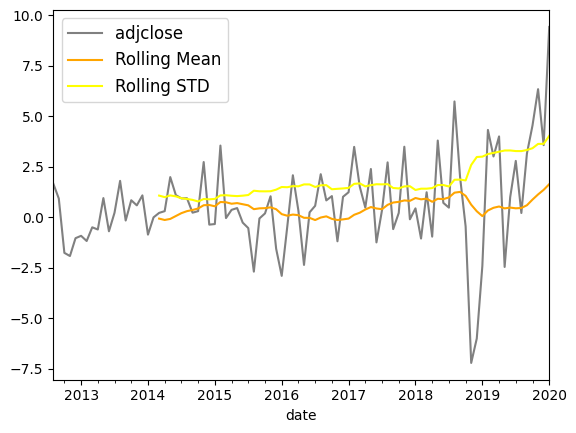

In [188]:
##Differencing By 1
monthly_diff = monthly_data['adjclose'] - monthly_data['adjclose'].shift(1)
monthly_diff[1:].plot(c='grey')
monthly_diff[1:].rolling(20).mean().plot(label='Rolling Mean',c='orange')
monthly_diff[1:].rolling(20).std().plot(label='Rolling STD',c='yellow')
plt.legend(prop={'size': 12})

In [189]:
##Checking if Time Series is Stationary by Running ADF Test
ad_fuller_func(monthly_diff[1:])

ADF Statistic: -5.293121
p-value: 0.000006
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584
Reject Null Hypothesis- Time Series is Stationary


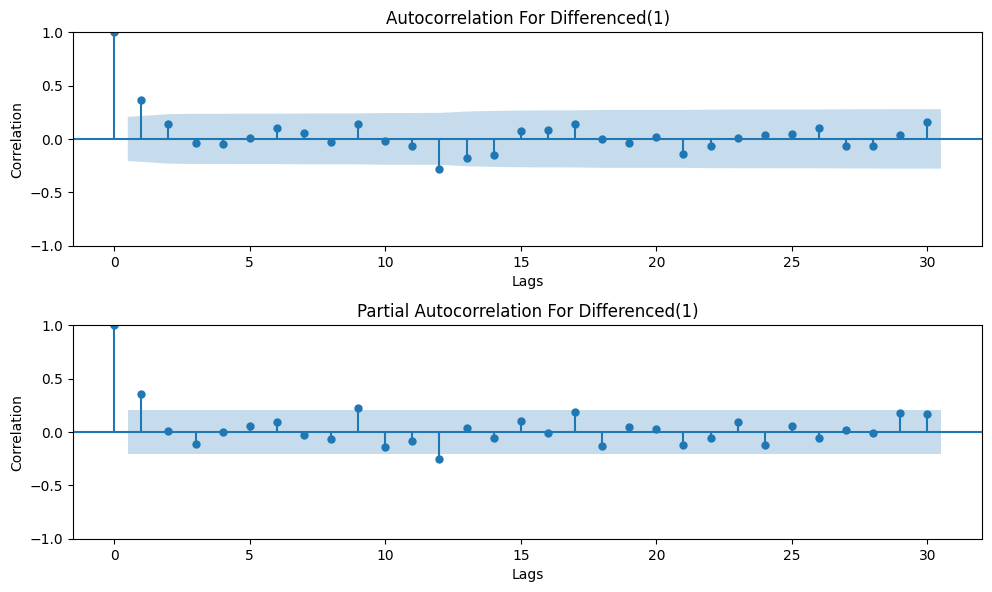

In [190]:
fig,(ax1,ax2) = plt.subplots(2,figsize=(10,6))
acf = plot_acf(monthly_diff[1:],lags=30,ax=ax1)
pacf = plot_pacf(monthly_diff[1:],lags=30,ax=ax2)
ax1.set_title('Autocorrelation For Differenced(1)')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Lags')
ax2.set_title('Partial Autocorrelation For Differenced(1)')
ax2.set_ylabel('Correlation')
ax2.set_xlabel('Lags')
plt.tight_layout(pad=1)

In [191]:
other_features=df.drop(columns='adjclose')

In [192]:
other_features['date'] = pd.to_datetime(other_features.date)
other_features.set_index('date',inplace=True)


In [193]:
other_features_num=other_features.drop(columns="sentiment_bert")
other_features_cal = other_features[['sentiment_bert']].copy()

In [194]:
other_features_num

,open,high,low,close,volume
date,,,,,
2012-07-23,21.228571,21.639286,20.989643,21.565357,487975600
2012-07-24,21.692142,21.774286,21.375357,21.461430,565132400
2012-07-27,20.536072,20.922501,20.413929,20.898571,403936400
2012-07-30,21.104286,21.408571,20.993570,21.251072,379142400
2012-07-31,21.543928,21.846430,21.525715,21.812857,462327600
...,...,...,...,...,...
2020-01-17,79.067497,79.684998,78.750000,79.682503,137816400
2020-01-21,79.297501,79.754997,79.000000,79.142502,110843200
2020-01-22,79.644997,79.997498,79.327499,79.425003,101832400


In [195]:
other_features_cal

,sentiment_bert
date,
2012-07-23,-1
2012-07-24,1
2012-07-27,0
2012-07-30,0
2012-07-31,-1
...,...
2020-01-17,0
2020-01-21,0
2020-01-22,0


In [196]:
# Create a DataFrame to hold the updated values
updated_df = other_features_num.copy()  # Make a copy of the original DataFrame

# Iterate over each column and update with the monthly means
for col in monthly_means.columns:
    # Iterate over each month in the resampled DataFrame
    for month in monthly_means.index:
        # Determine the start and end dates of the current month
        month_start = month.replace(day=1)
        month_end = month + pd.offsets.MonthEnd(0)

        # Update the values in 'updated_df' for the current month and column
        updated_df.loc[(updated_df.index >= month_start) & (updated_df.index <= month_end), col] = monthly_means.loc[month, col]

In [197]:
import pandas as pd

# Assuming you have 'other_features_num' DataFrame already defined

# Resample 'other_features_num' DataFrame by month and calculate the mode for each column
monthly_modes = other_features_cal.resample('M').apply(lambda x: x.mode().iloc[0])

# Create a DataFrame to hold the updated values (make a copy of the original DataFrame)
updated_df_cal = other_features_cal.copy()

# Iterate over each month and update 'updated_df' with the calculated modes
for month in monthly_modes.index:
    # Determine the start and end dates of the current month
    month_start = month.replace(day=1)
    month_end = month + pd.offsets.MonthEnd(0)

    # Get the mode values for the current month
    mode_values = monthly_modes.loc[month]

    # Reshape 'mode_values' to match the number of columns in the sliced DataFrame
    mode_values = mode_values.values.reshape(-1, updated_df_cal.loc[(updated_df_cal.index >= month_start) & (updated_df.index <= month_end)].shape[1])

    # Update the values in 'updated_df' for the current month
    updated_df_cal.loc[(updated_df.index >= month_start) & (updated_df.index <= month_end)] = mode_values

# Now 'updated_df' contains the mode values for each month in each column

In [198]:
other_features=merged_df = pd.concat([updated_df, updated_df_cal], axis=1)

In [199]:
other_features

,open,high,low,close,volume,sentiment_bert
date,,,,,,
2012-07-23,21.221000,21.518215,21.059643,21.397857,459702880.0,-1
2012-07-24,21.221000,21.518215,21.059643,21.397857,459702880.0,-1
2012-07-27,21.221000,21.518215,21.059643,21.397857,459702880.0,-1
2012-07-30,21.221000,21.518215,21.059643,21.397857,459702880.0,-1
2012-07-31,21.221000,21.518215,21.059643,21.397857,459702880.0,-1
...,...,...,...,...,...,...
2020-01-17,78.999723,79.624444,78.512221,79.076667,123971200.0,-1
2020-01-21,78.999723,79.624444,78.512221,79.076667,123971200.0,-1
2020-01-22,78.999723,79.624444,78.512221,79.076667,123971200.0,-1


In [200]:
# Assuming 'other_features' is your DataFrame containing the 'date' column

merged_df = pd.merge(monthly_data, other_features, left_index=True, right_index=True)
merged_df.drop(columns=['adjclose','Year','Month','Quarter'],inplace=True)

In [201]:
# Find common indices between df1 and df2
common_indices = monthly_data.index.intersection(merged_df.index)

# Keep rows in df1 where index matches with df2
filtered_monthly_date = monthly_data[monthly_data.index.isin(common_indices)]


In [202]:
filtered_monthly_date.shape

(58, 4)

In [203]:
merged_df.shape

(58, 6)

In [204]:
modelling_series = filtered_monthly_date['adjclose']
from sklearn.model_selection import train_test_split as split



In [205]:
len(modelling_series)

58

In [206]:
train,test = split(modelling_series,train_size=0.6,shuffle=False)

In [207]:
# Splitting the other features into training and testing sets using the same split as 'modelling_series'
train_other_features, test_other_features = split(merged_df,train_size=0.6,shuffle=False)

In [208]:
len(train)

34

In [209]:
len(train_other_features)

34

In [210]:
train_other_features=train_other_features.values
test_other_features=test_other_features.values

In [ ]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

list_param = []
list_param_seasonal=[]
list_results_aic=[]

from statsmodels.tsa.statespace.sarimax import SARIMAX
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                            exog=train_other_features
                            )

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

            list_param.append(param)
            list_param_seasonal.append(param_seasonal)
            list_results_aic.append(results.aic)
        except:
            continue

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:162.57571726565305
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:57.166199668626575


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:36.28442739751986
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:104.68716680350066


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:31.829429772321227
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:18.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:48.531067050770744
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:16.0
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:18.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:56.86039331911298
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:59.166199668626575


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:38.28442739751986
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:32.39469542583329


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:33.82942977232123
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:20.0
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:16.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:18.0
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:20.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:34.90579301034007
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:39.17232031228068


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:40.28442739751986
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:18.0
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:20.0
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:22.0
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:18.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:20.0
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:22.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:78.0288533898225
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:57.548412566060186


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:35.382380180314144
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:60.46008833225714


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:31.82168705660196
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:20.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:37.4053473756769
ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:18.0
ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:20.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:58.420186934277616
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:59.548412566060186


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 1)x(1, 0, 2, 12)12 - AIC:37.382380180314144
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:35.882046052787246


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:33.82168705660196
ARIMA(0, 0, 1)x(1, 1, 2, 12)12 - AIC:22.0
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:18.0
ARIMA(0, 0, 1)x(1, 2, 1, 12)12 - AIC:20.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:37.40580756950585
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:40.71081340641078


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

ARIMA(0, 0, 1)x(2, 0, 2, 12)12 - AIC:39.382380180314144
ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:20.0
ARIMA(0, 0, 1)x(2, 1, 1, 12)12 - AIC:22.0
ARIMA(0, 0, 1)x(2, 1, 2, 12)12 - AIC:24.0
ARIMA(0, 0, 1)x(2, 2, 0, 12)12 - AIC:20.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 1)x(2, 2, 1, 12)12 - AIC:22.0
ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:24.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:77.79719596020794
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:52.53446167484566


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:58.65635852129143


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:32.37627424803176
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:22.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:38.16759759177919
ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:20.0
ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:22.0
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:60.729845917000986


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:54.53446167484566


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:39.156521492103224


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:34.37627424803176
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:24.0
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:20.0
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:22.0
ARIMA(0, 0, 2)x(1, 2, 2, 12)12 - AIC:24.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:39.79607527878463
ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:42.851841927690785


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:38.30681636361601
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:22.0
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:26.0
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:22.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:24.0
ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:26.0


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. fore

ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:172.88363892712746
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:63.5781663195761


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/

ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:37.26145790402747
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:106.56927698390761


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:32.52690242636996
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:18.0


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting pa

ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:39.72823990844094
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:16.0
ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:18.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:64.41874516696478


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

Observations: 25
Training Observations: 14
Testing Observations: 11
Observations: 36
Training Observations: 25
Testing Observations: 11
Observations: 47
Training Observations: 36
Testing Observations: 11
Observations: 58
Training Observations: 47
Testing Observations: 11


<Figure size 640x480 with 0 Axes>

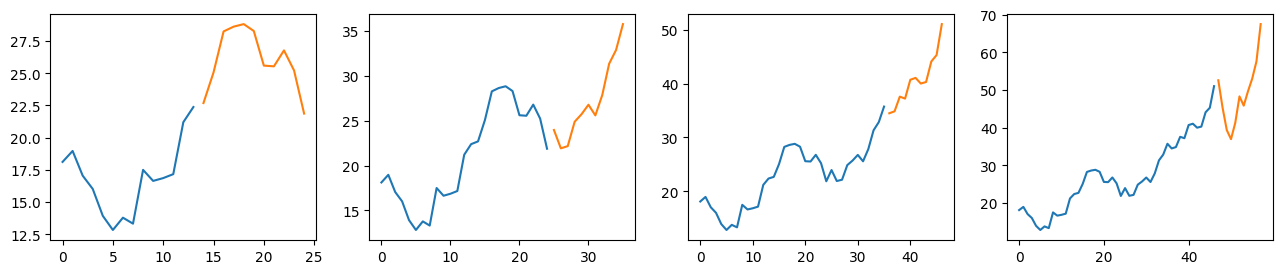

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

## Using TimeSeriesSplit from sklearn library
time_series_splits = TimeSeriesSplit(n_splits=4)
X = modelling_series.values
plt.figure(1)
fig = plt.figure(figsize=(24, 10))

index = 1
for train_index, test_index in time_series_splits.split(X):
 train = X[train_index]
 test = X[test_index]

 print('Observations: %d' % (len(train) + len(test)))
 print('Training Observations: %d' % (len(train)))
 print('Testing Observations: %d' % (len(test)))

 plt.subplot(360 + index)
 plt.plot(train)
 plt.plot([None for i in train] + [x for x in test])
    # pyplot.title(''.format())
 index += 1
plt.show()

In [211]:
len(train)

34

In [212]:
train_other_features

array([[ 2.12209998e+01,  2.15182148e+01,  2.10596428e+01,
         2.13978574e+01,  4.59702880e+08, -1.00000000e+00],
       [ 2.24039796e+01,  2.26057652e+01,  2.20249490e+01,
         2.23080357e+01,  6.17650800e+08,  0.00000000e+00],
       [ 1.99368878e+01,  2.01792094e+01,  1.96318621e+01,
         1.99626021e+01,  6.21473800e+08,  0.00000000e+00],
       [ 1.86953867e+01,  1.89425894e+01,  1.84901487e+01,
         1.87528868e+01,  4.97617167e+08,  0.00000000e+00],
       [ 1.63280519e+01,  1.64925002e+01,  1.60646427e+01,
         1.62383116e+01,  5.02463309e+08,  0.00000000e+00],
       [ 1.49218488e+01,  1.51703152e+01,  1.47321638e+01,
         1.49359874e+01,  5.53944753e+08,  0.00000000e+00],
       [ 1.59572096e+01,  1.61667635e+01,  1.57833928e+01,
         1.59752009e+01,  4.45545450e+08,  0.00000000e+00],
       [ 1.53594867e+01,  1.55222544e+01,  1.52504688e+01,
         1.54062276e+01,  3.05023425e+08,  0.00000000e+00],
       [ 1.99633792e+01,  2.01215934e+01,  1.983

In [213]:
len(train)

34

In [214]:
len(train_other_features)

34

In [215]:
modelling_series.index.min()

Timestamp('2012-07-31 00:00:00')

In [216]:
import pandas as pd

# Assuming modelling_series is your pandas Series or DataFrame
# Ensure the index of modelling_series is datetime-like
start_date = modelling_series.index.min()
end_date = modelling_series.index.max()

# Calculate the split point based on an 80-20 split
split_date = start_date + pd.DateOffset(days=int(0.8 * (end_date - start_date).days))

# Split the data into training and testing sets
train = modelling_series.loc[modelling_series.index < split_date]
test = modelling_series.loc[modelling_series.index >= split_date]

# Print start and end dates for train and test sets
print(f"Training Set: Start Date = {train.index.min()}, End Date = {train.index.max()}")
print(f"Testing Set: Start Date = {test.index.min()}, End Date = {test.index.max()}")


Training Set: Start Date = 2012-07-31 00:00:00, End Date = 2018-05-31 00:00:00
Testing Set: Start Date = 2018-07-31 00:00:00, End Date = 2019-12-31 00:00:00


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

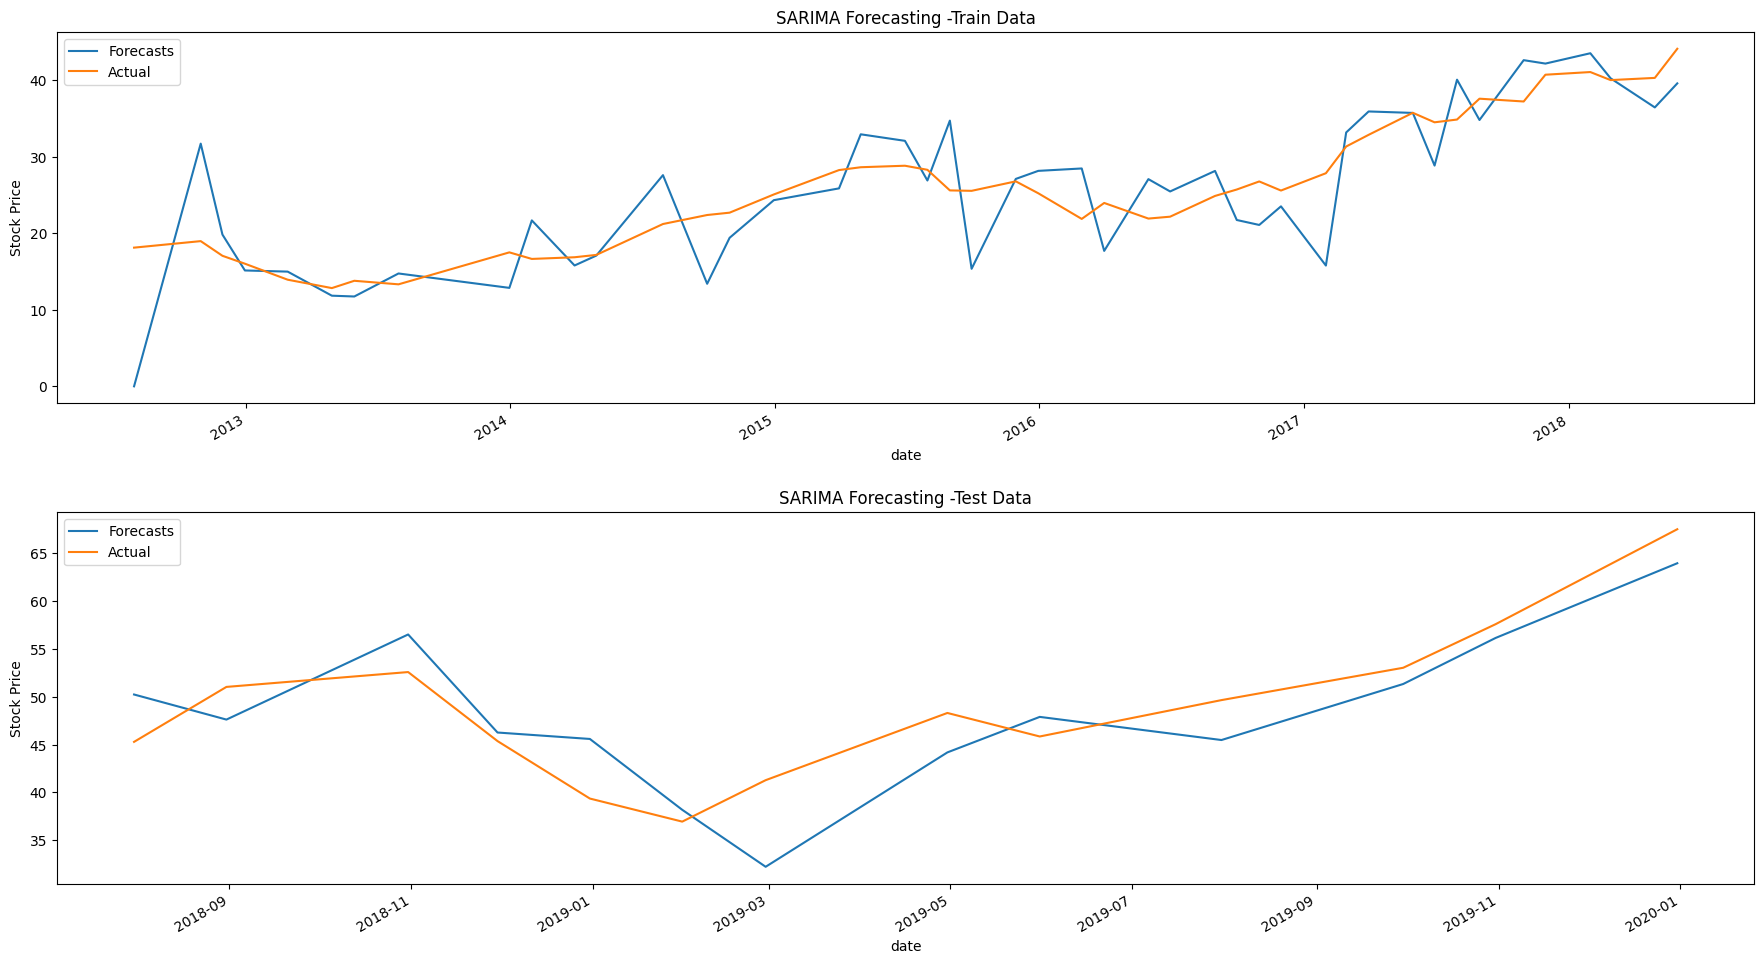

In [217]:
import statsmodels.api as sm
model = sm.tsa.SARIMAX(modelling_series,order=(2,2,1),seasonal_order=(1,2,2,12))
results=model.fit()
forecasts_train = results.predict(start='2012-07-31',end='2018-05-31')
forecasts_test = results.predict(start='2018-07-31',end='2019-12-31')

sd='2012-07-31'
ed='2018-05-31'
sd2='2018-07-31'
ed2='2019-12-31'

fig,(ax1,ax2) = plt.subplots(2,figsize=(18,10))

forecasts_train.plot(label='Forecasts',ax=ax1,title='SARIMA Forecasting -Train Data')
modelling_series.loc[sd:ed].plot(label='Actual',ax=ax1)
ax1.set_ylabel('Stock Price')

forecasts_test.plot(label='Forecasts',ax=ax2,title='SARIMA Forecasting -Test Data')
modelling_series.loc[sd2:ed2].plot(label='Actual',ax=ax2)
ax2.set_ylabel('Stock Price')

ax1.legend()
ax2.legend()
plt.tight_layout(pad=2)

In [218]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
##Function to Calculate Result Metrics
def result_metrics(test_series,forecast_series,model_name):
  print('Result Metrics for {}'.format(model_name))
  print('R2 Score : ',round(r2_score(test_series,forecast_series),3))
  print('Mean Squared Error : ',round(mean_squared_error(test_series,forecast_series),3))
  print('Mean Absolute Error : ',round(mean_absolute_error(test_series,forecast_series),3))

print(result_metrics(modelling_series[sd:ed],forecasts_train,'SARIMA-Train Data'))
print('----')
print(result_metrics(modelling_series[sd2:ed2],forecasts_test,'SARIMA-Test Data'))

Result Metrics for SARIMA-Train Data
R2 Score :  0.552
Mean Squared Error :  31.128
Mean Absolute Error :  4.199
None
----
Result Metrics for SARIMA-Test Data
R2 Score :  0.706
Mean Squared Error :  17.747
Mean Absolute Error :  3.594
None
